<h2>Sentiment Analysis using SVM - By Jyotika Rughoo & Appadoo Dave</h2>
<h4>Dataset taken from https://www.kaggle.com/crowdflower/twitter-airline-sentiment</h4>

In [1]:
# import important libraries
from sklearn import metrics
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re, string, nltk
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#import data
data = pd.read_csv("Tweets.csv")

#print head
data.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
data.info()
print('Dataset shape: ', data.shape, sep="") 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
# Finding how many missing data are there in the dataset
total = data.isnull().sum().sort_values(ascending=False)
percent = round(((data.isnull().sum() / data.isnull().count())*100),2).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Missing values', '% of Total values'])
missing_data

,Missing values,% of Total values
negativereason_gold,14608,99.78
airline_sentiment_gold,14600,99.73
tweet_coord,13621,93.04
negativereason,5462,37.31
user_timezone,4820,32.92
tweet_location,4733,32.33
negativereason_confidence,4118,28.13
tweet_created,0,0.00
text,0,0.00
retweet_count,0,0.00


In [5]:
# negativereason_gold, airline_sentiment_gold and tweet_coord has more than 90% missing
del data['tweet_coord']
del data['airline_sentiment_gold']
del data['negativereason_gold']
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
#filter data based on training sentiment confidence
data_clean = data.copy()
data_clean = data_clean[data_clean['airline_sentiment_confidence'] > 0.65]

In [7]:
data_clean.info()
print('Dataset shape: ', data_clean.shape, sep="") 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13651 entries, 0 to 14639
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      13651 non-null  int64  
 1   airline_sentiment             13651 non-null  object 
 2   airline_sentiment_confidence  13651 non-null  float64
 3   negativereason                8787 non-null   object 
 4   negativereason_confidence     9720 non-null   float64
 5   airline                       13651 non-null  object 
 6   name                          13651 non-null  object 
 7   retweet_count                 13651 non-null  int64  
 8   text                          13651 non-null  object 
 9   tweet_created                 13651 non-null  object 
 10  tweet_location                9245 non-null   object 
 11  user_timezone                 9137 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 1.4+ MB
Dat

In [8]:
data_clean.groupby('airline').count()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,name,retweet_count,text,tweet_created,tweet_location,user_timezone
airline,,,,,,,,,,,
American,2615,2615,2615,1895,2064,2615,2615,2615,2615,1752,1691
Delta,2030,2030,2030,890,1045,2030,2030,2030,2030,1458,1472
Southwest,2223,2223,2223,1116,1297,2223,2223,2223,2223,1470,1530
US Airways,2763,2763,2763,2194,2340,2763,2763,2763,2763,1761,1759
United,3555,3555,3555,2521,2767,3555,3555,3555,3555,2451,2338
Virgin America,465,465,465,171,207,465,465,465,465,353,347


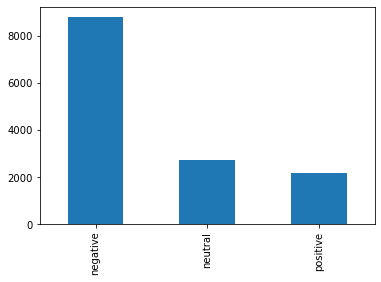

In [9]:
data_clean['airline_sentiment'].value_counts().plot(kind='bar')


Total number of tweets for each airline 
airline
United            3555
US Airways        2763
American          2615
Southwest         2223
Delta             2030
Virgin America     465
Name: airline_sentiment, dtype: int64


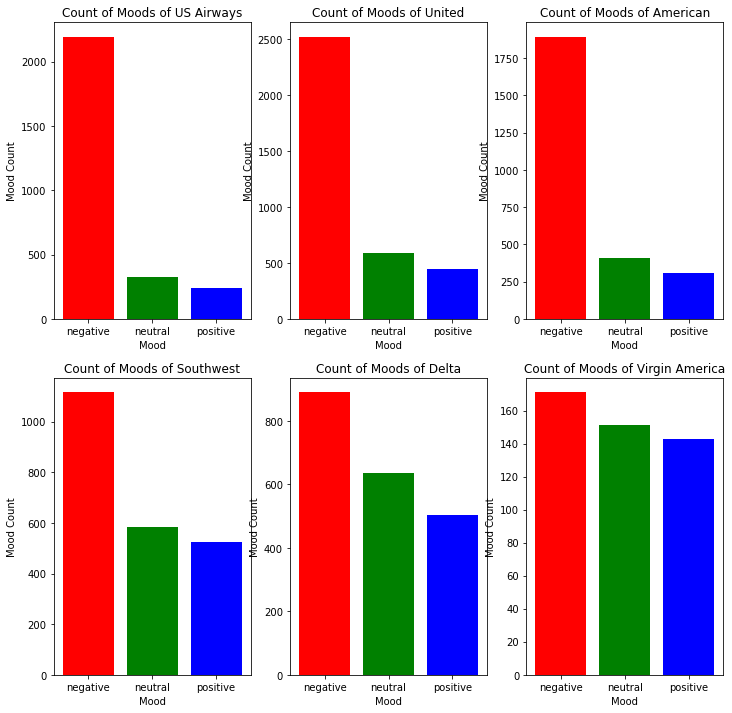

In [10]:
print("Total number of tweets for each airline \n", data_clean.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False), sep="")
airlines = ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_data = data_clean[data_clean['airline']==i]
    count = new_data['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

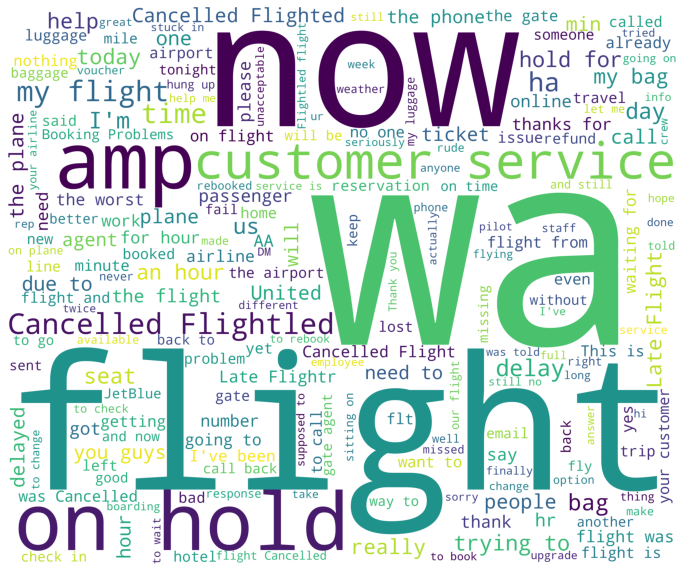

In [11]:
from wordcloud import WordCloud,STOPWORDS

new_data = data_clean[data_clean['airline_sentiment']=='negative']
words = ' '.join(new_data['text'])
cleaned_word = " ".join([word for word in words.split() if 'http' not in word and not word.startswith('@') and word != 'RT'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=3000, height=2500).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_clean, test_size=0.2, random_state=0)
train_tweets = train['text'].values  # x_train
test_tweets = test['text'].values  # x_test
train_sentiments = train['airline_sentiment']  # y_train
test_sentiments = test['airline_sentiment']  # y_test


In [13]:
# import english stopwords
#  stop word is a commonly used word such as “the”, “a”, “an”, “in”
stopword_list = nltk.corpus.stopwords.words('english') 

# Tokenize divides a string into substrings or splitting a sentence into words.
def tokenize(text): 
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
    return tknzr.tokenize(text)

# if token is in stopword_list, remove it
def remove_stopwords(text):
    tokens = tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# carrying out the two above functions
def normalize_corpus(corpus):
    normalized_corpus = []
    for index, text in enumerate(corpus):
        text = text.lower()
        text = remove_stopwords(text)
        normalized_corpus.append(text)
    return normalized_corpus

In [14]:
# normalization
norm_train = normalize_corpus(train_tweets)
# feature extraction  
# the CountVectorizer builds a vocab of known words and encode them as a matrix
# ngram_range : 'I am groot' contains 'i am ' and 'am groot' but 'i am groot' is 3gram
vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer = tokenize)
train_features = vectorizer.fit_transform(norm_train).astype(float)


In [15]:
# normalize test tweets                        
norm_test = normalize_corpus(test_tweets)  
# extract features                                     
test_features = vectorizer.transform(norm_test)

#### Using SVC C-Support Vector Classification

In [16]:
# build the model
# SVC C-Support Vector Classification.
from sklearn.svm import SVC
svm_SVC = SVC(kernel = 'rbf', random_state = 0)  # 0.8070303917978763 for linear
svm_SVC.fit(train_features, train_sentiments)

SVC(random_state=0)

In [17]:
# accuracy on testing
print("Score using C-Support Vector classification with RBF kernel = ", end="")
print(svm_SVC.score(test_features, test_sentiments))

Score using C-Support Vector classification with RBF kernel =0.8019040644452582


#### Using Stochastic Gradient Descent

In [18]:
# Using the Stochastic Gradient Descent 
# It calculates the gradient of the loss and updates the model accordingly with a learning rate
# max_iter is epochs
from sklearn.linear_model import SGDClassifier
svm = SGDClassifier(max_iter=30)
svm.fit(train_features, train_sentiments)

SGDClassifier(max_iter=30)

In [19]:
# accuracy on testing
print("Score using Stochastic Gradient Descent = ", end="")
print(svm.score(test_features, test_sentiments))

Score using Stochastic Gradient Descent = 0.8180153789820579


In [20]:
# prediect sentiment
predicted_sentiments = svm.predict(test_features)

In [21]:
# print evaluation mesures report
report = metrics.classification_report(y_true=test_sentiments, y_pred=predicted_sentiments, output_dict=True)
df = pd.DataFrame(report).transpose()
df
# Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
# Recall is the ratio of correctly predicted positive observations to the all observations in actual class.
# F1 Score is the weighted average of Precision and Recall. It takes both false positives and false negatives into account.
# The support is the number of samples of the true response that lie in that class.

,precision,recall,f1-score,support
negative,0.869589,0.903825,0.886376,1778.000000
neutral,0.640919,0.585878,0.612164,524.000000
positive,0.792079,0.745921,0.768307,429.000000
accuracy,0.818015,0.818015,0.818015,0.818015
macro avg,0.767529,0.745208,0.755616,2731.000000
weighted avg,0.813538,0.818015,0.815216,2731.000000


In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_sentiments , predicted_sentiments)
print(cm)

[[1607  125   46]
 [ 179  307   38]
 [  62   47  320]]


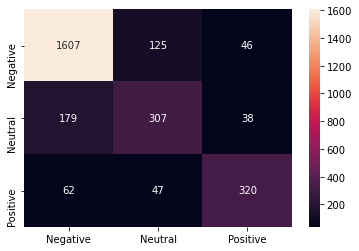

In [23]:
x_axis_labels = ['Negative', 'Neutral', 'Positive'] # labels for x-axis
y_axis_labels = ['Negative', 'Neutral', 'Positive'] # labels for y-axis

# create seabvorn heatmap with required labels
sns.heatmap(cm, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt='g')

In [24]:
sample = ["flying with @united is a great experience"]
# normalize test tweets                        
norm_sample = normalize_corpus(sample)  
# extract features                                     
sample_features = vectorizer.transform(norm_sample)
# accuracy on testing
print(svm.predict(sample_features))

['positive']


In [25]:
sample = ["flying with @united is always a great experience. If you don't lose your luggage"]
# normalize test tweets                        
norm_sample = normalize_corpus(sample)  
# extract features                                     
sample_features = vectorizer.transform(norm_sample)
# accuracy on testing
print(svm.predict(sample_features))

['negative']


In [26]:
sample = ["cookies"]
# normalize test tweets                        
norm_sample = normalize_corpus(sample)  
# extract features                                     
sample_features = vectorizer.transform(norm_sample)
# accuracy on testing
print(svm.predict(sample_features))

['neutral']


In [27]:
datatest = ["flying with @united is always a great experience", "I dont like that", "@united very bad experience!", "flying with @united is always a great experience. If you don't lose your luggage"]
newdata = vectorizer.transform(datatest)
print(svm.predict(newdata))

['positive' 'neutral' 'negative' 'negative']


#### Using Random Forest Classification

In [28]:
from sklearn.ensemble import RandomForestClassifier
rdfrst = RandomForestClassifier(n_estimators=10)  # kept n_estimators to 10 instead of 200 since it takes quite some time to run on my machine
rdfrst.fit(train_features, train_sentiments)

RandomForestClassifier(n_estimators=10)

In [29]:
# accuracy on testing
print("Score using Random Forest Classifier = ", end=" ")
print(rdfrst.score(test_features, test_sentiments))

Score using Random Forest Classifier =  0.7597949469058953


In [30]:
# Extract single tree
estimator = rdfrst.estimators_[5]

# Convert to svg using system command (requires Graphviz installed and added to path)
from subprocess import call
from sklearn.tree import export_graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', rounded = True, proportion = False, precision = 2, filled = True)
call(['dot', '-Tsvg', 'tree.dot', '-o', 'tree.svg'])

0

In [31]:
from IPython.display import SVG, display
# display the decision trees. It is easier to view tree.svg in Chrome browser
# display(SVG('tree.svg'))